In [250]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from sqlalchemy import create_engine
import warnings
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')

In [272]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'
table_name = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

life_df = pd.read_sql_query('select * from lifeexpectancy',con=engine)

engine.dispose()

## Data Cleaning

In [252]:
life_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
Country                            2938 non-null object
Year                               2938 non-null int64
Status                             2938 non-null object
Life expectancy                    2928 non-null float64
Adult Mortality                    2928 non-null float64
infant deaths                      2938 non-null int64
Alcohol                            2744 non-null float64
percentage expenditure             2938 non-null float64
Hepatitis B                        2385 non-null float64
Measles                            2938 non-null int64
 BMI                               2904 non-null float64
under-five deaths                  2938 non-null int64
Polio                              2919 non-null float64
Total expenditure                  2712 non-null float64
Diphtheria                         2919 non-null float64
 HIV/AIDS                          2938 non-null

In [253]:
life_df.isnull().sum()*100/life_df.isnull().count()

Country                             0.000000
Year                                0.000000
Status                              0.000000
Life expectancy                     0.340368
Adult Mortality                     0.340368
infant deaths                       0.000000
Alcohol                             6.603131
percentage expenditure              0.000000
Hepatitis B                        18.822328
Measles                             0.000000
 BMI                                1.157250
under-five deaths                   0.000000
Polio                               0.646698
Total expenditure                   7.692308
Diphtheria                          0.646698
 HIV/AIDS                           0.000000
GDP                                15.248468
Population                         22.191967
 thinness  1-19 years               1.157250
 thinness 5-9 years                 1.157250
Income composition of resources     5.684139
Schooling                           5.547992
dtype: flo

In [254]:
life_df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


### Missing Values

In [273]:
life_df.columns = life_df.columns.str.strip()
life_df = life_df.dropna(subset = ["Life expectancy"])

In [274]:
fill_list = ["Alcohol", "Hepatitis B", "BMI", "Polio", "Total expenditure", "Diphtheria", "GDP", "Population",
             "thinness  1-19 years", "thinness 5-9 years", "Income composition of resources", "Schooling"]

countries = life_df["Country"].unique()

for country in countries:
    life_df.loc[life_df["Country"] == country, fill_list] = life_df.loc[life_df["Country"] == 
                                                            country, fill_list].interpolate()

life_df.dropna(inplace=True)

For missing values I used interpolation since the data is a time series. I ran interpolation per country

### Outliers

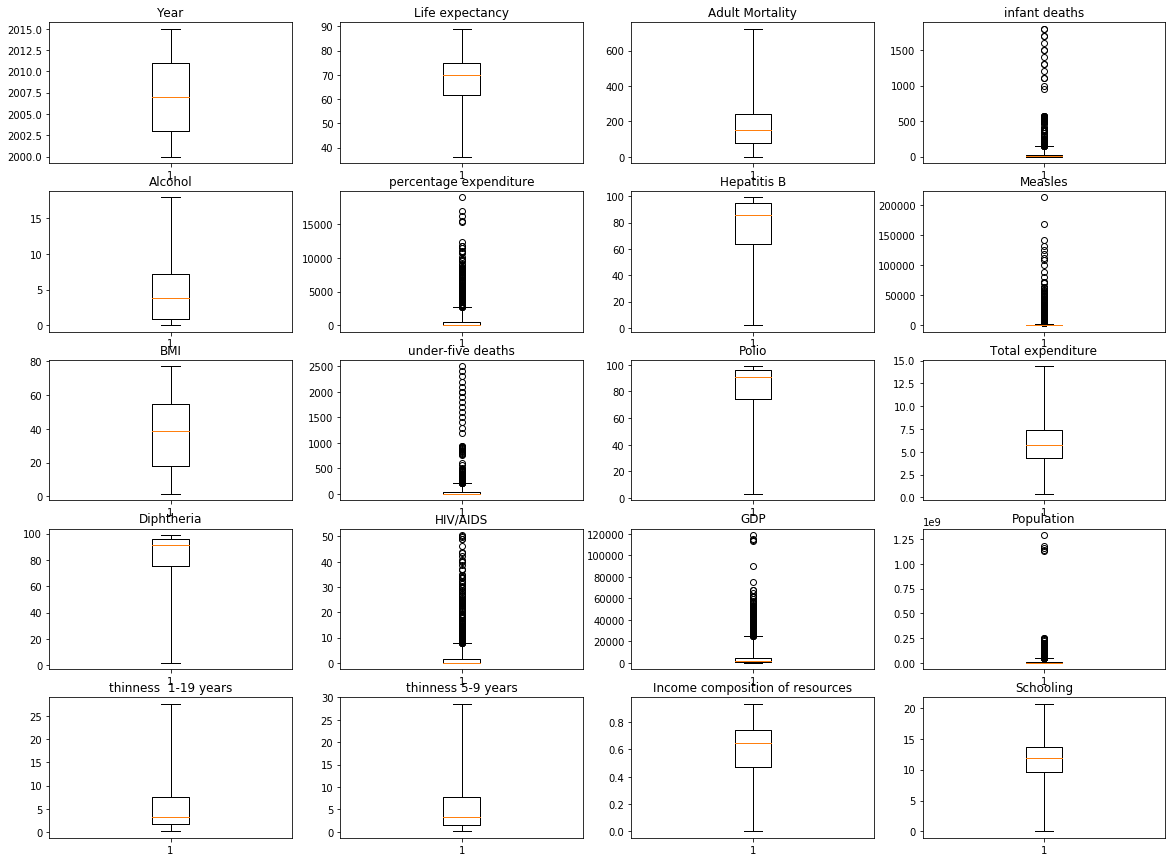

In [232]:
features = ["Year", "Life expectancy", "Adult Mortality", "infant deaths", "Alcohol", "percentage expenditure", 
            "Hepatitis B", "Measles", "BMI", "under-five deaths", "Polio", "Total expenditure", "Diphtheria", "HIV/AIDS", 
            "GDP", "Population", "thinness  1-19 years", "thinness 5-9 years", "Income composition of resources", 
            "Schooling"]

plt.figure(figsize = (20,15))
for i in range(0, len(features)):
    plt.subplot(5,4,i+1)
    plt.boxplot(life_df[features[i]], whis = 5)
    plt.title(features[i])

7 features has outliers, and they are (infant deaths, percentage expenditure, Measles, under-five deaths, HIV/AIDS, GDP, and Population). these outliers could affect descriptive sattistics like mean and as a result might affect the model and its accuracy because it might be sensitive to these extreme values. 

In [275]:
outlier_features = ["infant deaths" , "percentage expenditure" , "Measles" , "under-five deaths" , "HIV/AIDS" , "GDP" , 
                    "Population"]
for feature in outlier_features:
    life_df[feature + "_win"] = winsorize(life_df[feature], (0.10, 0.10))

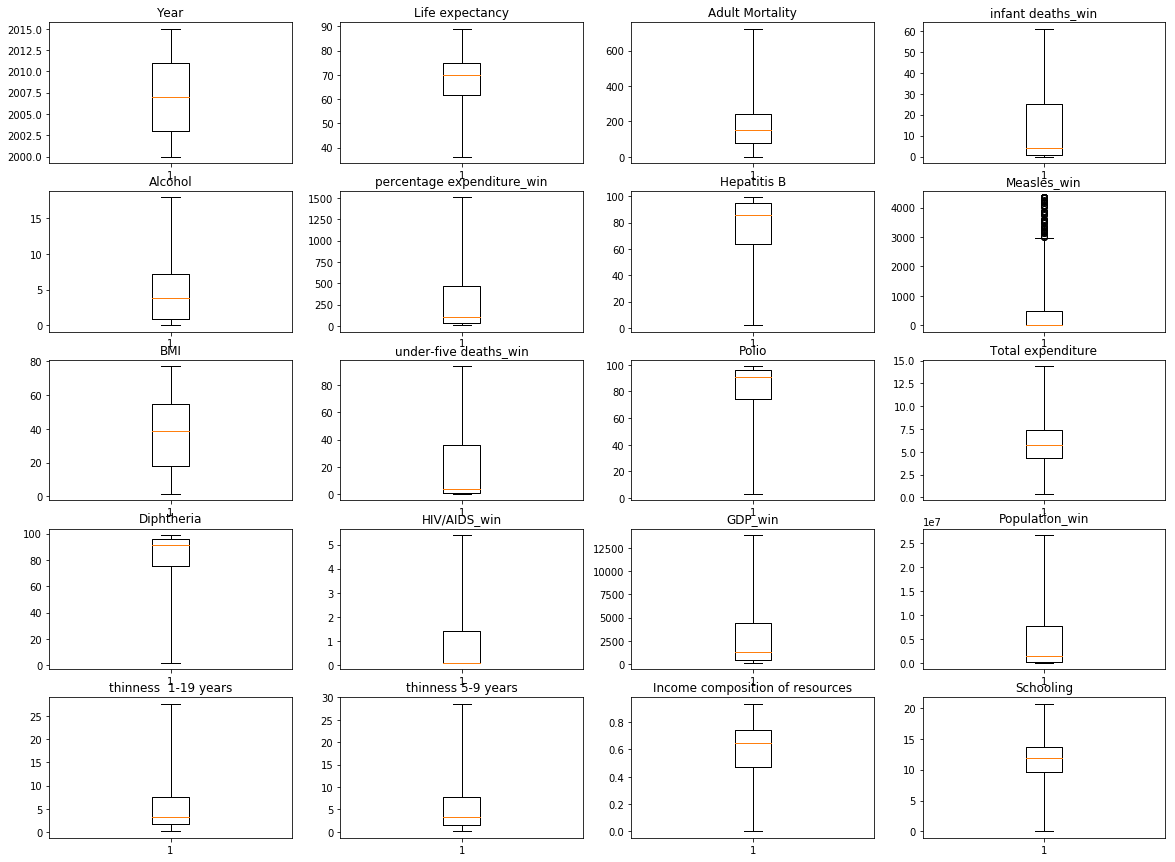

In [281]:
winsorized_features = ["Year", "Life expectancy", "Adult Mortality", "infant deaths_win", "Alcohol", 
                       "percentage expenditure_win", "Hepatitis B", "Measles_win", "BMI", "under-five deaths_win", 
                       "Polio", "Total expenditure", "Diphtheria", "HIV/AIDS_win", "GDP_win", "Population_win", 
                       "thinness  1-19 years", "thinness 5-9 years", "Income composition of resources", "Schooling"]

plt.figure(figsize = (20,15))
for i in range(0, len(winsorized_features)):
    plt.subplot(5,4,i+1)
    plt.boxplot(life_df[winsorized_features[i]], whis = 5)
    plt.title(winsorized_features[i])

In [276]:
life_df["Measles"].describe()

count      1987.000000
mean       2729.561651
std       12102.389143
min           0.000000
25%           0.000000
50%          20.000000
75%         499.500000
max      212183.000000
Name: Measles, dtype: float64

In [277]:
life_df = life_df.replace({"Measles" : {0: 0.000000001}})
life_df["Measles"].describe()

count    1.987000e+03
mean     2.729562e+03
std      1.210239e+04
min      1.000000e-09
25%      1.000000e-09
50%      2.000000e+01
75%      4.995000e+02
max      2.121830e+05
Name: Measles, dtype: float64

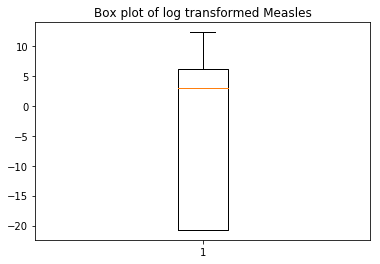

In [278]:
life_df["Mesales_log"] = np.log(life_df["Measles"])
plt.boxplot(life_df["Mesales_log"])
plt.title("Box plot of log transformed Measles")
plt.show()

First, the features with outliers has been transformed using wisorize function. The box plots revealed no outliers except for feature "Mesales". For this feature, a log transformation managed to take care of the outliers.

## Data Exploration

In [280]:
life_df.describe(include = "all")

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Income composition of resources,Schooling,infant deaths_win,percentage expenditure_win,Measles_win,under-five deaths_win,HIV/AIDS_win,GDP_win,Population_win,Mesales_log
count,1987,1987.000000,1987,1987.000000,1987.000000,1987.000000,1987.000000,1987.000000,1987.00000,1.987000e+03,...,1987.000000,1987.000000,1987.000000,1987.000000,1987.000000,1987.000000,1987.000000,1987.000000,1.987000e+03,1987.000000
unique,133,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Afghanistan,NaN,Developing,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,16,NaN,1702,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2006.984902,NaN,67.981782,175.187217,36.623553,4.455644,685.492318,73.86160,2.729562e+03,...,0.603453,11.639054,15.502265,349.573422,729.262204,22.736286,1.166985,3405.010018,5.946202e+06,-3.129612
std,NaN,4.323147,NaN,9.706401,131.616942,138.784913,3.976733,1761.669050,29.02807,1.210239e+04,...,0.206026,3.212964,20.877993,476.404340,1404.210482,32.151641,1.810159,4361.550707,8.701181e+06,12.256279
min,NaN,2000.000000,NaN,36.300000,1.000000,0.000000,0.010000,0.000000,2.00000,1.000000e-09,...,0.000000,0.000000,0.000000,7.806043,0.000000,0.000000,0.100000,134.326189,2.827600e+04,-20.723266
25%,NaN,2003.000000,NaN,61.700000,75.000000,1.000000,0.830000,29.469887,64.00000,1.000000e-09,...,0.473000,9.700000,1.000000,29.469887,0.000000,1.000000,0.100000,384.553107,1.967480e+05,-20.723266
50%,NaN,2007.000000,NaN,69.900000,153.000000,4.000000,3.770000,104.314473,86.00000,2.000000e+01,...,0.648000,11.900000,4.000000,104.314473,20.000000,4.000000,0.100000,1334.651896,1.396861e+06,2.995732
75%,NaN,2011.000000,NaN,74.700000,243.000000,25.000000,7.190000,470.870122,95.00000,4.995000e+02,...,0.745000,13.700000,25.000000,470.870122,499.500000,36.000000,1.400000,4441.530655,7.625918e+06,6.213567


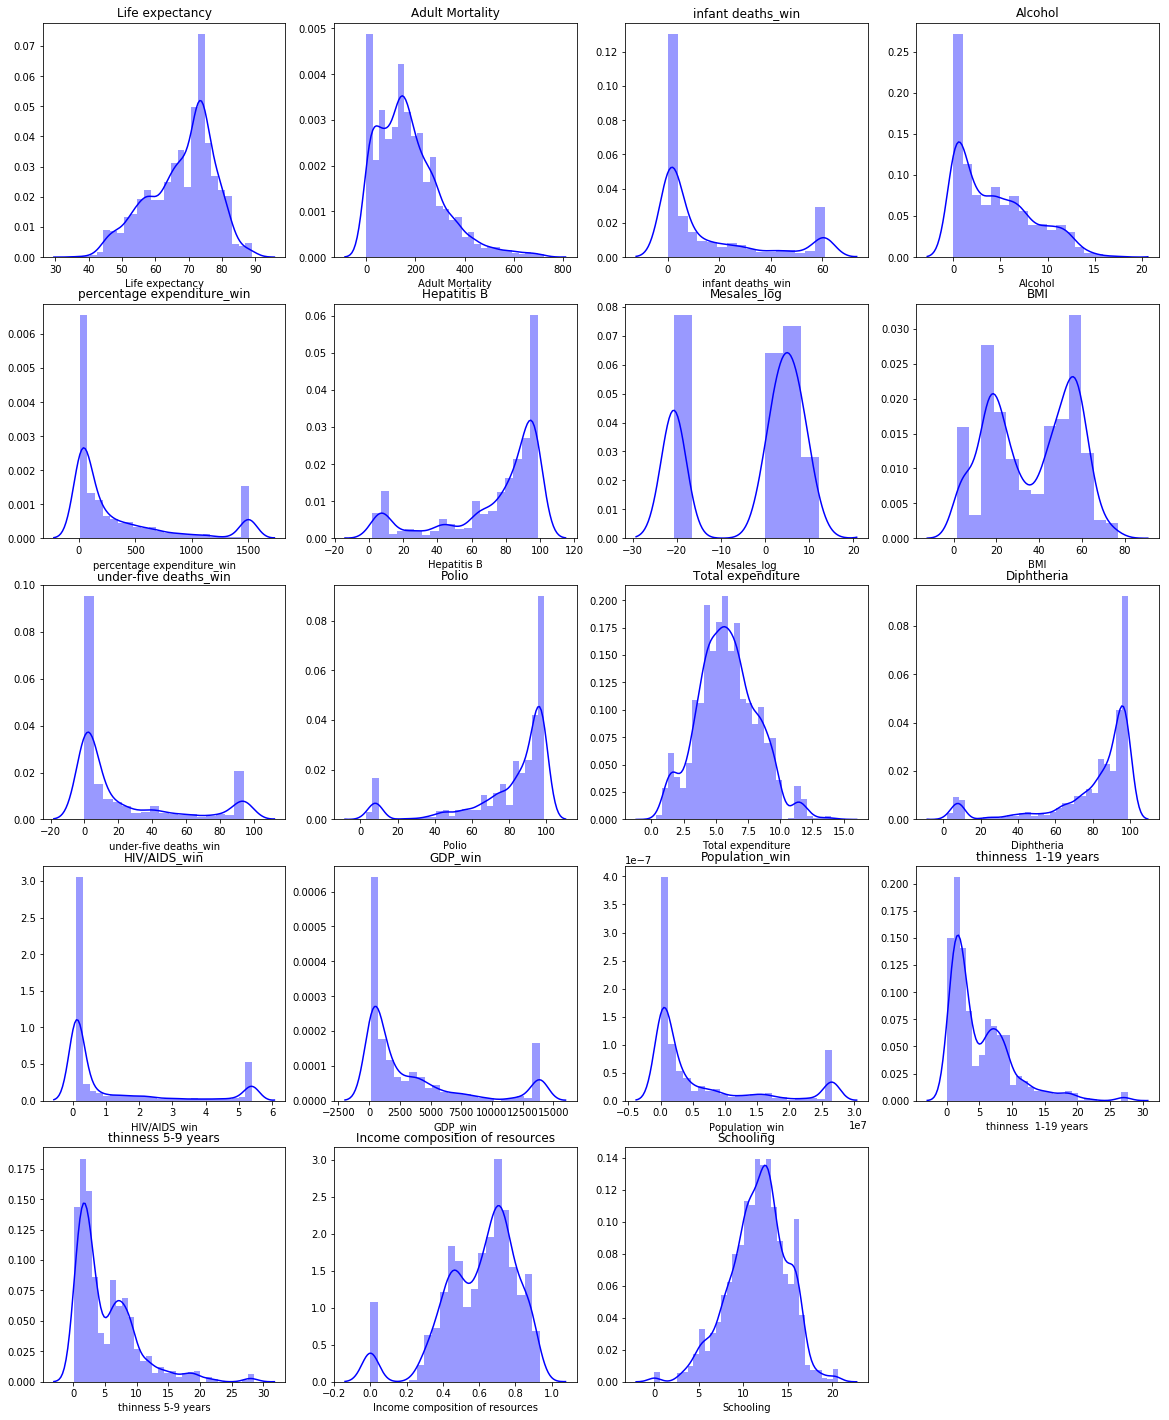

In [289]:
cont_features = ["Life expectancy", "Adult Mortality", "infant deaths_win", "Alcohol", "percentage expenditure_win", 
                 "Hepatitis B", "Mesales_log", "BMI", "under-five deaths_win", "Polio", "Total expenditure", "Diphtheria", 
                 "HIV/AIDS_win", "GDP_win", "Population_win", "thinness  1-19 years", "thinness 5-9 years", 
                 "Income composition of resources", "Schooling"]

plt.figure(figsize = (20,25))
for i in range(0, len(cont_features)):
    plt.subplot(5,4,i+1)
    sns.distplot(life_df[cont_features[i]], color = "blue")
    plt.title(cont_features[i])

Most of the plots are not following the normal distribution with few features distribution are close to the normal distribution with some skewenes 

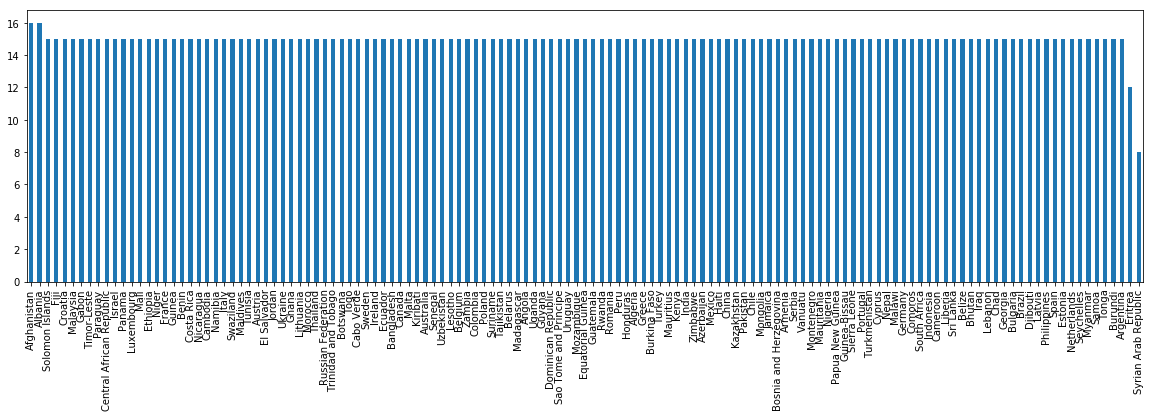

In [312]:
plt.figure(figsize = (20,5))
life_df['Country'].value_counts().plot.bar()

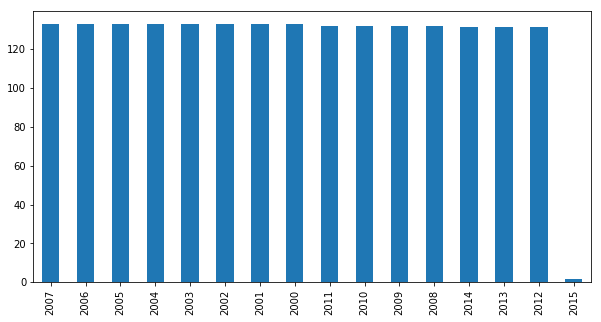

In [314]:
plt.figure(figsize = (10,5))
life_df['Year'].value_counts().plot.bar()

In [316]:
life_df.loc[life_df["Year"] == 2015]

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Income composition of resources,Schooling,infant deaths_win,percentage expenditure_win,Measles_win,under-five deaths_win,HIV/AIDS_win,GDP_win,Population_win,Mesales_log
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1.154000e+03,...,0.479,10.1,61,71.279624,1154,83,0.1,584.25921,26625845.0,7.050989
16,Albania,2015,Developing,77.8,74.0,0,4.60,364.975229,99.0,1.000000e-09,...,0.762,14.2,0,364.975229,0,0,0.1,3954.22783,28873.0,-20.723266


In [319]:
life_df[life_df.Country.str.contains("Syrian")]

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Income composition of resources,Schooling,infant deaths_win,percentage expenditure_win,Measles_win,under-five deaths_win,HIV/AIDS_win,GDP_win,Population_win,Mesales_log
2545,Syrian Arab Republic,2007,Developing,73.8,121.0,8,0.83,17.981362,83.0,403.0,...,0.644,11.5,8,17.981362,403,9,0.1,258.352900,1963286.0,5.998937
2546,Syrian Arab Republic,2006,Developing,73.7,123.0,8,0.97,122.652333,83.0,517.0,...,0.636,11.4,8,122.652333,517,10,0.1,1762.246170,18914977.0,6.248043
2547,Syrian Arab Republic,2005,Developing,73.5,127.0,9,0.92,116.258594,83.0,375.0,...,0.624,11.0,9,116.258594,375,10,0.1,1577.457182,18294611.0,5.926926
2548,Syrian Arab Republic,2004,Developing,73.2,131.0,9,0.93,10.211298,82.0,189.0,...,0.610,10.6,9,10.211298,189,10,0.1,148.852738,1786638.0,5.241747
2549,Syrian Arab Republic,2003,Developing,73.0,134.0,9,1.29,94.756392,81.0,801.0,...,0.599,10.3,9,94.756392,801,11,0.1,1253.391430,17415266.0,6.685861
2550,Syrian Arab Republic,2002,Developing,72.8,135.0,9,1.25,91.703568,8.0,538.0,...,0.596,10.2,9,91.703568,538,11,0.1,1263.134550,178791.0,6.287859
2551,Syrian Arab Republic,2001,Developing,72.7,135.0,10,1.29,93.500751,8.0,290.0,...,0.589,10.1,10,93.500751,290,11,0.1,1258.421953,16766899.0,5.669881
2552,Syrian Arab Republic,2000,Developing,72.6,136.0,10,1.41,81.727471,79.0,146.0,...,0.588,10.0,10,81.727471,146,12,0.1,1177.629268,1641848.0,4.983607


In [320]:
life_df[life_df.Country.str.contains("Eritrea")]

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Income composition of resources,Schooling,infant deaths_win,percentage expenditure_win,Measles_win,under-five deaths_win,HIV/AIDS_win,GDP_win,Population_win,Mesales_log
855,Eritrea,2011,Developing,62.9,286.0,6,0.62,20.979919,96.0,4.800000e+01,...,0.405,5.0,6,20.979919,48,8,0.7,582.775532,447469.0,3.871201
856,Eritrea,2010,Developing,62.1,298.0,6,0.61,17.357398,9.0,5.100000e+01,...,0.404,5.1,6,17.357398,51,9,0.9,482.149940,43984.0,3.931826
857,Eritrea,2009,Developing,61.4,311.0,6,0.63,1.575160,92.0,8.200000e+01,...,0.402,5.2,6,7.806043,82,9,1.0,134.326189,431334.0,4.406719
858,Eritrea,2008,Developing,67.0,322.0,6,0.49,11.765723,94.0,1.000000e-09,...,0.406,5.2,6,11.765723,0,9,1.1,326.825642,4232636.0,-20.723266
859,Eritrea,2007,Developing,62.0,329.0,6,1.23,11.423860,91.0,5.500000e+01,...,0.405,5.3,6,11.423860,55,9,1.3,317.329434,4153332.0,4.007333
860,Eritrea,2006,Developing,59.7,336.0,7,0.97,10.602698,94.0,1.280000e+02,...,0.405,5.3,7,10.602698,128,9,1.4,297.828588,466648.0,4.852030
861,Eritrea,2005,Developing,59.4,34.0,7,1.07,5.064689,96.0,1.900000e+01,...,0.000,5.4,7,7.806043,19,9,1.6,276.758960,39697.0,2.944439
862,Eritrea,2004,Developing,59.1,342.0,7,0.64,10.260973,84.0,2.400000e+01,...,0.000,5.0,7,10.260973,24,10,1.8,287.422224,3858623.0,3.178054
863,Eritrea,2003,Developing,58.8,343.0,7,0.56,6.913998,91.0,3.760000e+02,...,0.000,4.7,7,7.806043,376,10,1.9,232.794546,3738265.0,5.929589
864,Eritrea,2002,Developing,58.5,343.0,7,0.83,0.703132,86.0,4.600000e+02,...,0.000,4.4,7,7.806043,460,10,1.9,134.326189,3614639.0,6.131226


All the 133 countries are represnted equaly in the data sample with 15 years worth of data. Only "Afghanstan" and "Albania" were represented more (16 years), and they are the only countries with that fopr the year 2015. Syria (8 years)(2000-2007) and Eritrea (12 years)(2000-2011) where represented less.

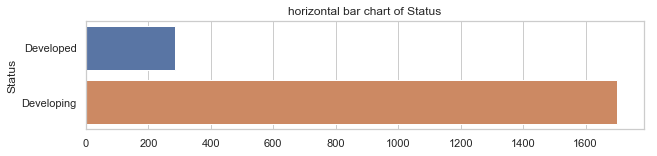

In [328]:
plt.figure(figsize=(10,2))
sns.set(style="whitegrid")
sns.barplot(x= life_df.groupby("Status")["Status"].count(),
            y= life_df.groupby("Status")["Status"].count().index) 
plt.title("horizontal bar chart of Status")
plt.xlabel("")
plt.show()

Almost 85% of the data in this study comes from developing countries, which showes representation close to the actual proportion of developing countries compare to developed countries.

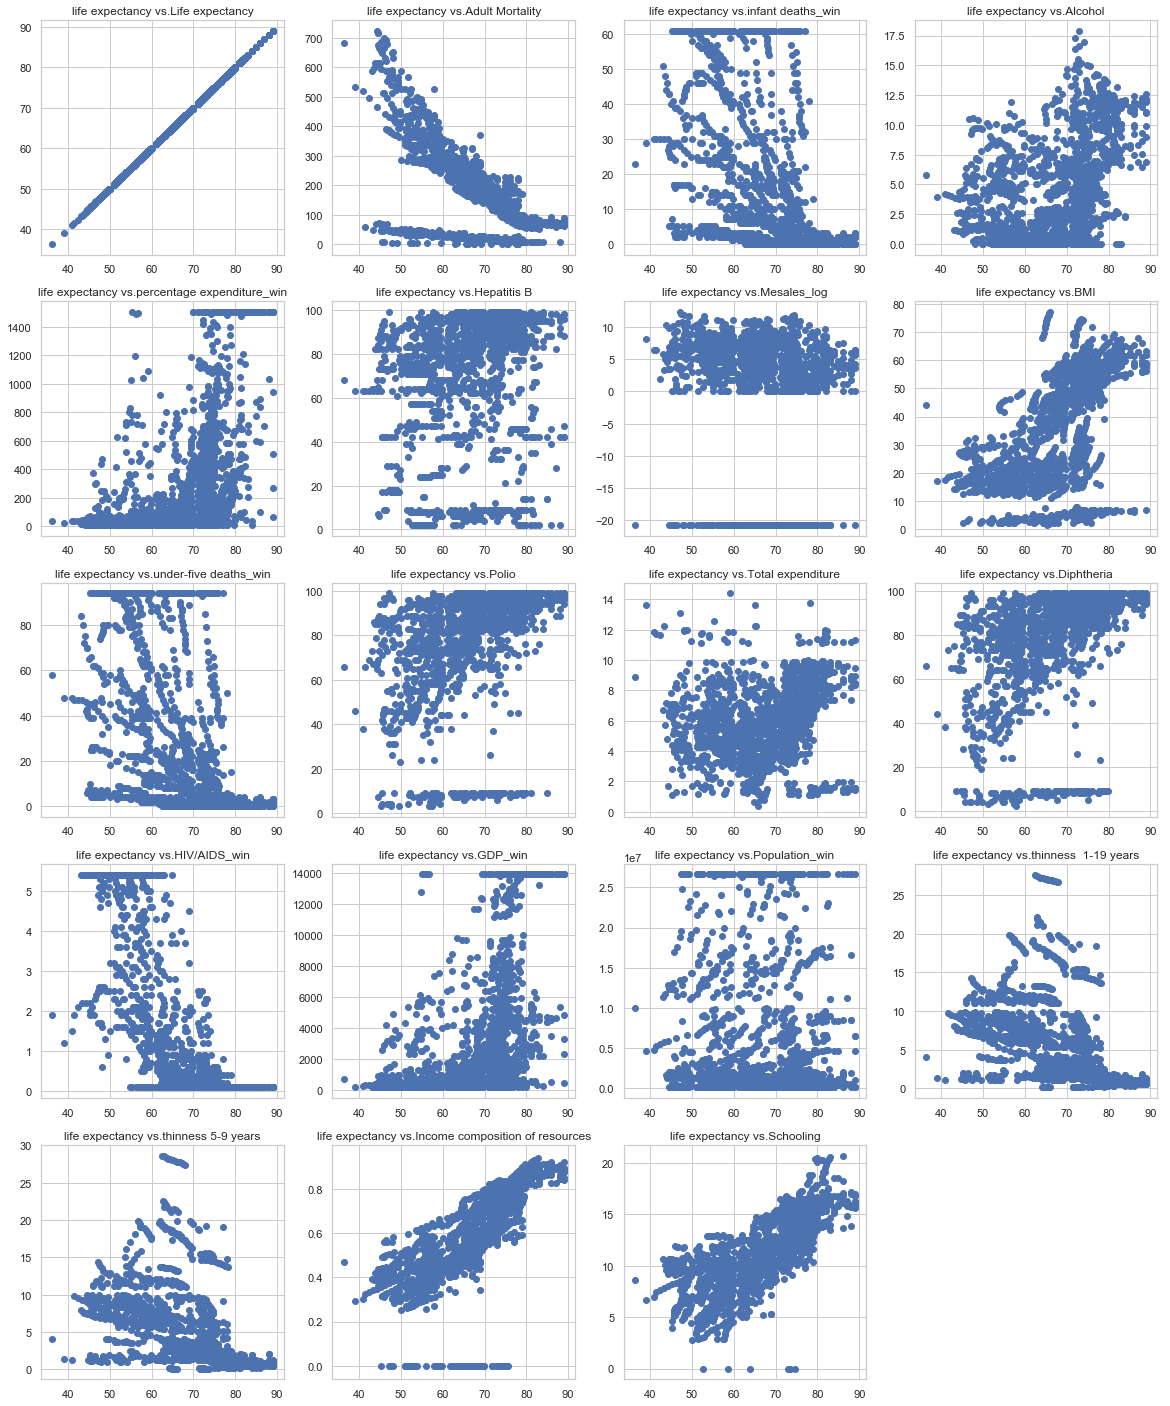

In [335]:
cont_features = ["Life expectancy", "Adult Mortality", "infant deaths_win", "Alcohol", "percentage expenditure_win", 
                 "Hepatitis B", "Mesales_log", "BMI", "under-five deaths_win", "Polio", "Total expenditure", "Diphtheria", 
                 "HIV/AIDS_win", "GDP_win", "Population_win", "thinness  1-19 years", "thinness 5-9 years", 
                 "Income composition of resources", "Schooling"]

plt.figure(figsize = (20,25))
for i in range(0, len(cont_features)):
    plt.subplot(5,4,i+1)
    plt.scatter(life_df["Life expectancy"], life_df[cont_features[i]])
    plt.title("life expectancy vs." + cont_features[i])

The scatter plots does not show strong correlation between the features and the target variable "Life Expectancy". Some features such as "Adult Mortality" "Income composrition of resources", and "schooling" showes better correlation with the target varibales than the rest of the features. the correlation was negative with the first and positive with the other two features, which makes sense.

Text(0.5, 1.0, 'Correlation Matrix (Life)')

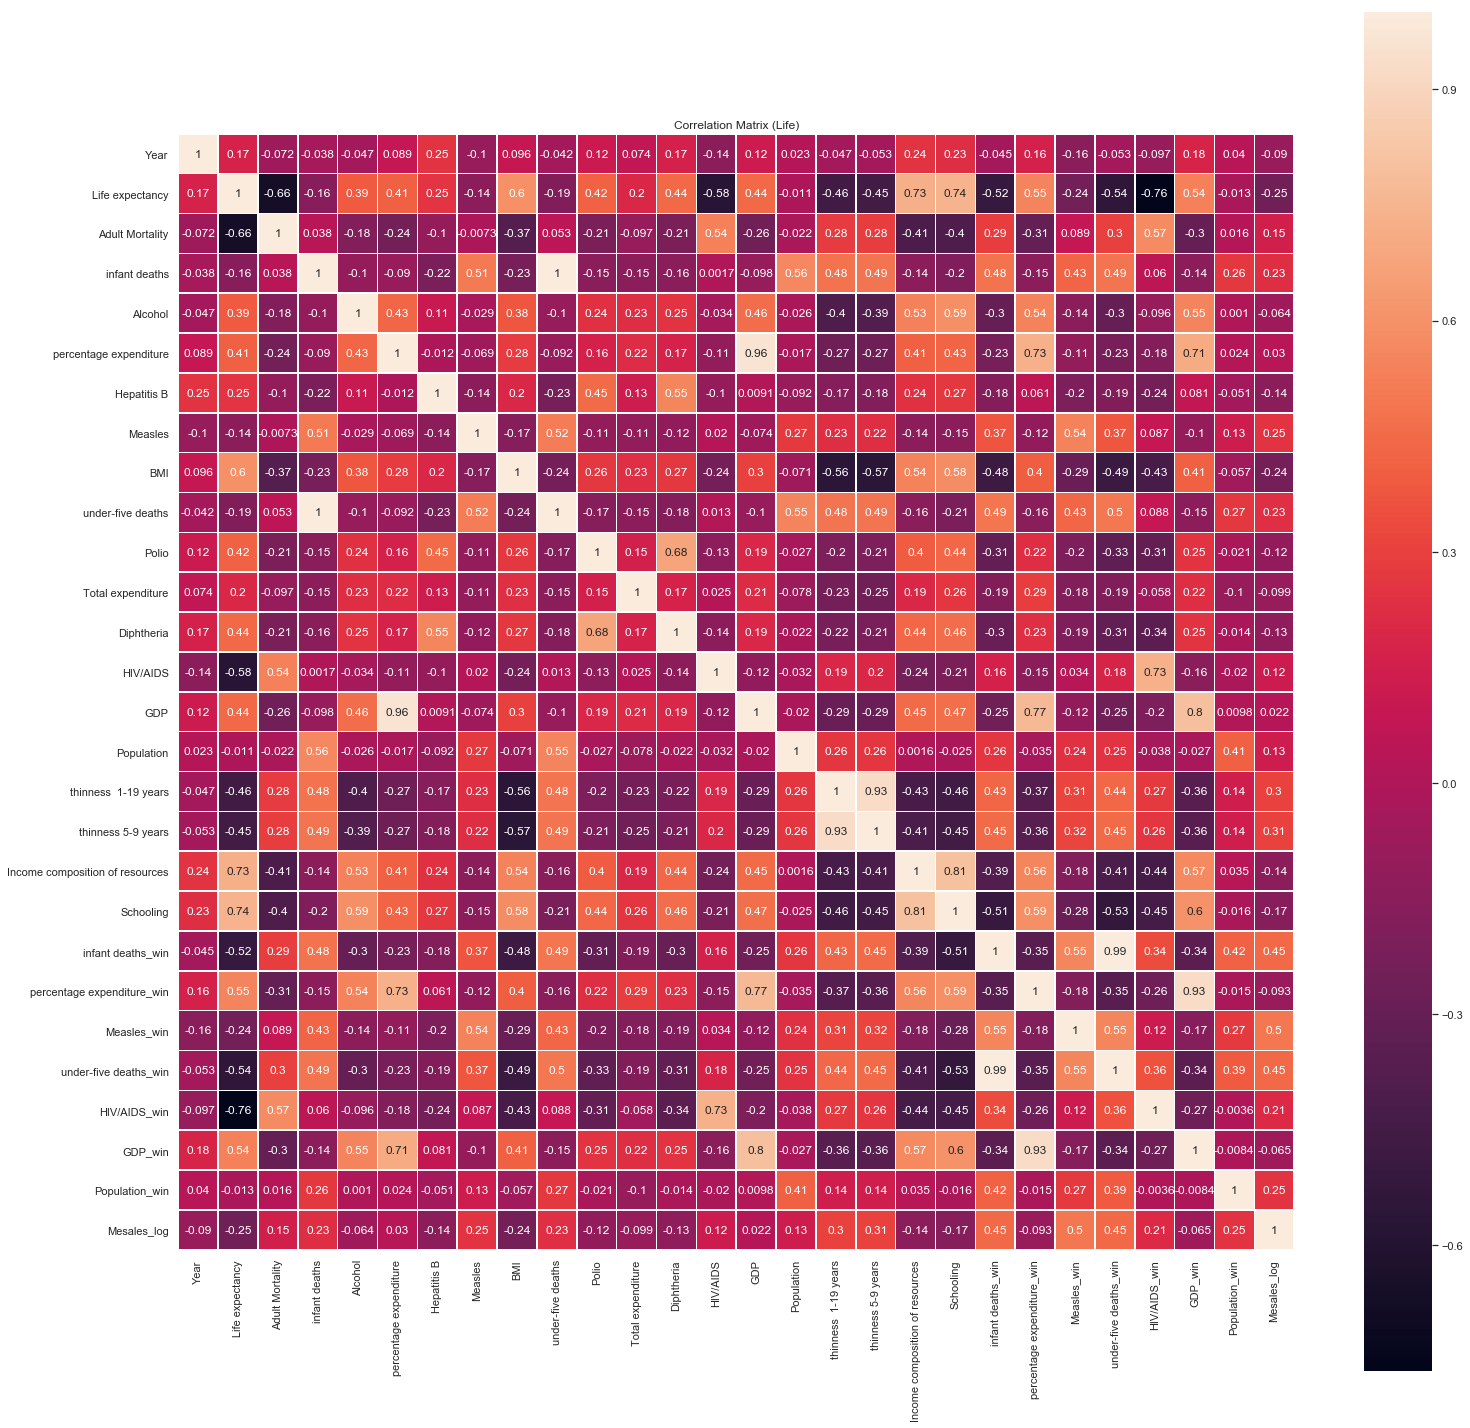

In [339]:
corrmat_life = life_df.corr()

plt.figure(figsize = (25,25))
sns.heatmap(corrmat_life, square = True, annot = True, linewidths = 0.5)
plt.title("Correlation Matrix (Life)")

From the heat map we can find the following:

Life Expectancy (Target variable) has a relativly strong positive correlation with "Income composition of resources", and "schooling"), this means good income and long schooling years is associated with long life expectancy which is the case in most developed countries.

In the other hand Life Expectancy (Target variable) has a relativly strong negative correlation with "HIV/AIDS" and "Adult Mortality". these make sense sense more mortality reduces the lide expectancy.

There are some high correlation between some features such as:

- Infant deaths and under 5 deaths (corr = 0.99)
- percent expenditure and GDP (corr = 0.93)
- thinness 1-19 years and thinness 5-9 years (corr = 0.93)
- Income composition of resources and Schooling (corr = 0.81)

We have be careful of using this variables to build the model because the correlation between these variables might affect the model accuracy, espicially if we know that two of these features are highly correlated with each other and with the target variable as well.

In [342]:
year = life_df.groupby("Year").mean()

,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,...,Income composition of resources,Schooling,infant deaths_win,percentage expenditure_win,Measles_win,under-five deaths_win,HIV/AIDS_win,GDP_win,Population_win,Mesales_log
Year,,,,,,,,,,,,,,,,,,,,,
2000,65.469925,191.240602,45.135338,4.336917,379.865790,60.248120,5473.526316,33.339850,64.541353,72.616541,...,0.501398,10.163910,17.075188,214.648442,1317.736842,25.436090,1.305263,2123.134721,5.314077e+06,-1.196872
2001,65.907519,186.714286,44.285714,4.304662,446.056303,60.323308,5566.932331,34.513534,62.451128,74.390977,...,0.540301,10.623308,16.842105,257.612307,1297.225564,25.082707,1.342105,2520.412859,6.291242e+06,-1.398578
2002,66.097744,182.616541,42.669173,4.501805,357.911933,63.751880,3473.804511,35.628571,60.263158,78.751880,...,0.545647,10.838346,16.631579,229.390117,1121.293233,24.676692,1.353383,2248.423760,5.022737e+06,-1.983636
2003,66.153383,172.578947,41.796992,4.525263,497.594461,65.406015,4499.406015,35.186466,58.105263,77.781955,...,0.550090,11.004511,16.383459,278.404028,908.819549,24.293233,1.351128,2676.069110,5.891613e+06,-1.500195
2004,66.435338,198.781955,40.180451,4.585714,678.122880,69.052632,3082.857143,35.230075,56.218045,77.112782,...,0.563865,11.263158,16.120301,299.593221,831.676692,23.932331,1.339850,2883.241804,5.076211e+06,-2.311624
2005,67.136090,172.511278,38.526316,4.678985,574.487404,73.812030,2957.398496,33.654135,53.872180,78.744361,...,0.578662,11.415789,15.894737,328.307345,587.804511,23.466165,1.313534,2985.187510,6.125667e+06,-3.142240
2006,67.636090,180.751880,37.781955,4.777218,765.033974,76.255639,2111.804511,36.012782,52.609023,82.624060,...,0.612684,11.569925,15.736842,339.064365,487.195489,23.112782,1.275188,3224.465050,5.961483e+06,-2.372862
2007,68.076692,169.368421,36.187970,4.885940,702.054381,76.909774,1545.766917,34.718045,50.609023,83.067669,...,0.619519,11.699248,15.451128,329.602308,368.458647,22.706767,1.245865,3190.611324,6.206733e+06,-4.416219
2008,68.396212,184.325758,35.015152,4.907803,1082.019611,79.977273,1858.666667,36.241667,49.098485,84.325758,...,0.626621,11.857576,15.371212,384.986780,432.681818,22.530303,1.184091,3981.764892,6.122720e+06,-4.517017


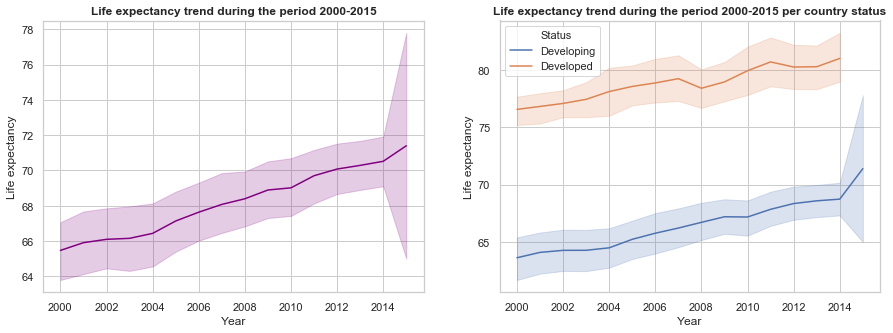

In [428]:
plt.figure(figsize = (15,5))
plt.subplot (1,2,1)
sns.lineplot(x = "Year", y = "Life expectancy", data = life_df, color = "purple")
plt.title("Life expectancy trend during the period 2000-2015", fontweight="bold")

plt.subplot(1,2,2)
sns.lineplot(x = "Year", y = "Life expectancy", data = life_df, hue = "Status")
plt.title("Life expectancy trend during the period 2000-2015 per country status", fontweight="bold")

plt.show()

Life expectancy is increasing over years. It has incresed from 65 years in 2000 to 70-71 years in 2014-2015. In the right side plot, the trend is positive in both developed and developing countries with almost equal gap (~15 years) between the two groups of countries

## Feature Selection

From the above Correlation Matrix the following variables will be selected to build the model:
- HIV/Aids_win : The winersized number of deaths per 1000 live births becuae of HIV/Aids is the heighest correlated variables with the target variable (-0.76). As the number of deaths increases as the life expectancy decreases.
- Schooling : This variable is the second highest correlated variable with the target variable (0.74). it make sense since more education might lead to more life expectancy becuase citizen are living in country with many educated people.
- Adult Mortality : the mortality rates of adults per 1000 population is negatively correlated (-0.66) with the target variable. as the death rate increases, the life expectancy decreases.
- percentage expenditure_win: the winersized percentage of health as a percentage of GDP per capita is positivly correlated with the target variables (0.55). As the percentage oif health expenditures increases as the life expectancy increases.
- under-five deaths_win: the winersized number of under 5 deaths per 1000 population. it is negativly correlated (-0.54) with the target varibale
- Status: it is a categorical feature. It was clear that life expectancy is significantly higher for developed countries compare to developing countries. This feature is important if we want to build a model to predict life expectancy at any country because location makes difference.

The following variables are discarded and is not recommended to be included in building themodel:
- Income composoition of resources becuase of it is high correlation with schooling which has been choosen to be included.
- GDP_win because it is correlated with percentage expenditure_win which better correlated with the target varibale and more specific to health.
- infants deaths_win because it is correlated with under 5 deaths_win and because it is part of the  second mentioned feature. It is better to use under 5 deaths_win variable because it includes the infants deaths as well and because it is higher correlated with the target variable.
- All other variables do not have more than 0.5 correlation with the target variable and it is preferable to discard them

## Summary

life expectancy is increasing over the years. it has increaed by almost 9% during (2000-2015). people live in developed countries live 15 years more in average compare to developing countries, this gap did not change during the above mentioned period.

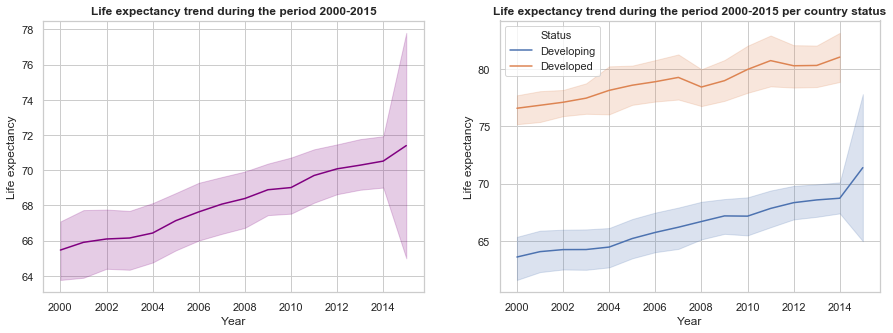

In [427]:
plt.figure(figsize = (15,5))
plt.subplot (1,2,1)
sns.lineplot(x = "Year", y = "Life expectancy", data = life_df, color = "purple")
plt.title("Life expectancy trend during the period 2000-2015", fontweight="bold")

plt.subplot(1,2,2)
sns.lineplot(x = "Year", y = "Life expectancy", data = life_df, hue = "Status")
plt.title("Life expectancy trend during the period 2000-2015 per country status", fontweight="bold")

plt.show()

It has been notices that the life expectancy is relatively high in countries where:
- Governaments invest relatively high percentage of thier GDP per capita on health which shows the iportance of health care investment.
- High Number of years schooling which shows the important of education.
The correlation between these features and the life expectancy is shown i the below plot in green.

The life expectancy is relatively short in countries where:
- The number of HIV/AIDS deaths is high
- High number of under five deaths
- High ration of adult mortality 

these features shows that lake of proper healthcare and safe environment affect negatively the life expectancy in most of the developing countries. The difference of 15 years life expectancy in favor of developed countries is due to their high investment on healthcare and education. educating people and providing proper healthcare will make them live longer. this could be the formula for developing countries to increase thier life expectancy to the level of developed countries.

Text(0.5, 0, '')

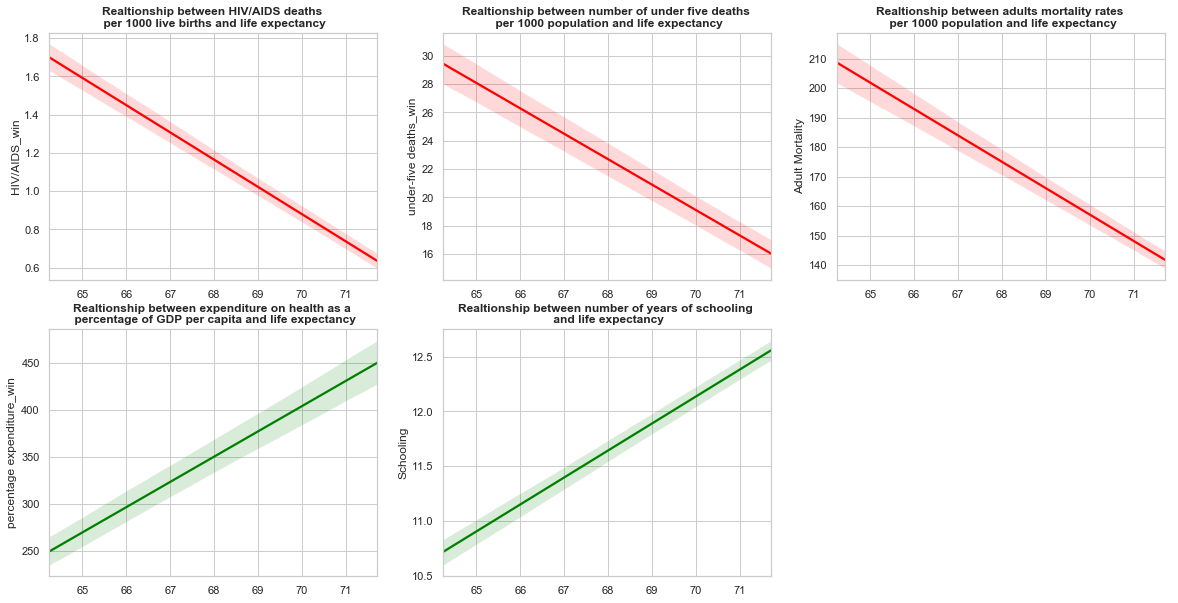

In [453]:
plt.figure(figsize = (20,10))
plt.subplot (2,3,1)
sns.regplot(x = life_df["Life expectancy"], y = life_df["HIV/AIDS_win"], scatter=False, line_kws={"color": "red"}, 
            data = life_df)
plt.title("Realtionship between HIV/AIDS deaths \n per 1000 live births and life expectancy", fontweight="bold")
plt.xlabel("")

plt.subplot (2,3,2)
sns.regplot(x = life_df["Life expectancy"], y = life_df["under-five deaths_win"], scatter=False, line_kws={"color": "red"}, 
            data = life_df)
plt.title("Realtionship between number of under five deaths \n per 1000 population and life expectancy", fontweight="bold")
plt.xlabel("")

plt.subplot (2,3,3)
sns.regplot(x = life_df["Life expectancy"], y = life_df["Adult Mortality"], scatter=False, line_kws={"color": "red"}, 
            data = life_df)
plt.title("Realtionship between adults mortality rates \n per 1000 population and life expectancy", fontweight="bold")
plt.xlabel("")

plt.subplot (2,3,4)
sns.regplot(x = life_df["Life expectancy"], y = life_df["percentage expenditure_win"], scatter=False,
            line_kws={"color": "green"}, data = life_df)
plt.title("Realtionship between expenditure on health as a \n percentage of GDP per capita and life expectancy", 
          fontweight="bold")
plt.xlabel("")

plt.subplot (2,3,5)
sns.regplot(x = life_df["Life expectancy"], y = life_df["Schooling"], scatter=False, line_kws={"color": "green"}, 
            data = life_df)
plt.title("Realtionship between number of years of schooling \n and life expectancy", fontweight="bold")
plt.xlabel("")